# Imports

In [247]:
from fastai import *
from fastai.tabular import *
from fastai.callbacks import SaveModelCallback

In [294]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
np.set_printoptions(threshold=np.inf)

path = Path(os.getcwd() + '\data')

pd.set_option('display.max_rows', None)

# Load Data

In [249]:
df_train = pd.read_csv(path/'train.csv', index_col='PassengerId')
df_test = pd.read_csv(path/'test.csv', index_col='PassengerId')

In [250]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Feature engineering

In [251]:
titles_dict = {'Capt.': 'Other',
               'Major.': 'Other',
               'Jonkheer.': 'Other',
               'Don.': 'Other',
               'Sir.': 'Other',
               'Dr.': 'Other',
               'Rev.': 'Other',
               'Countess.': 'Other',
               'Dona.': 'Other',
               'Mme.': 'Mrs',
               'Mlle.': 'Miss',
               'Ms.': 'Miss',
               'Mr.': 'Mr',
               'Mrs.': 'Mrs',
               'Miss.': 'Miss',
               'Master.': 'Master',
               'Lady.': 'Other'}

def get_title(name):
    return name.split(',')[1].split(' ')[1]

def create_title_column(df):
    df['Title'] = df['Name'].apply(get_title)
    df['Title'] = df['Title'].map(titles_dict)
    
create_title_column(df_train)
create_title_column(df_test)

In [252]:
def create_family_size_column(df):
    df['FamilySize'] = df['SibSp'] + df['Parch']
    
create_family_size_column(df_train)
create_family_size_column(df_test)

In [253]:
fam_names = df_train.Name.apply(lambda x: x.split(',')[0])

fam_names2 = df_test.Name.apply(lambda x: x.split(',')[0])
fam_names.value_counts()

# fam_names2.isin(fam_names).value_counts()

Andersson                 9
Sage                      7
Goodwin                   6
Johnson                   6
Skoog                     6
Panula                    6
Carter                    6
Rice                      5
Smith                     4
Lefebre                   4
Williams                  4
Palsson                   4
Brown                     4
Fortune                   4
Gustafsson                4
Asplund                   4
Baclini                   4
Kelly                     4
Ford                      4
Hart                      4
Harris                    4
Harper                    4
Vander Planke             3
Johansson                 3
Hansen                    3
Moran                     3
Jussila                   3
O'Brien                   3
Bourke                    3
Hoyt                      3
Boulos                    3
Elias                     3
Taussig                   3
Flynn                     3
Jensen                    3
Collyer             

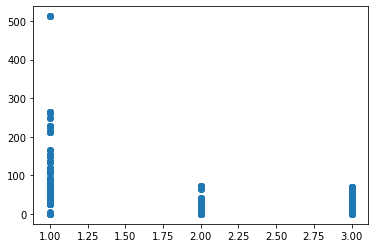

In [254]:
plt.scatter(df_train.Pclass, df_train.Fare)

In [255]:
df_train.Title.value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Other      20
Name: Title, dtype: int64

# Clean Data

In [256]:
df_train.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)
df_test.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)

df_test.loc[1044, 'Fare']= df_train.Fare.mean()

# Data analysis

In [257]:
cat_names = ['Pclass', 'Sex', 'Embarked', 'Title']
emb_szs = {
    'Pclass': 1,
    'Sex': 1,
    'Embarked': 1,
    'Title':1
}

# Training

In [258]:
procs = [FillMissing, Categorify, Normalize]
valid_idx = df_train.sample(frac=0.2, random_state=42).index
dep_var = 'Survived'
epochs = 1

In [289]:
class OPTIMAL_AC(Callback):
    _order = -20 #Needs to run before the recorder
        
    def __init__(self, learn, **kwargs): 
        self.learn = learn
        self.output, self.target = [], []
        
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['OPTIMAL_AC'])
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
    
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = self.find_best_acc(preds, target)
            
            return add_metrics(last_metrics, [metric])
         
    def find_best_acc(self, preds, target):
        df = pd.DataFrame({'pred': preds.cpu().numpy()[:,1],
                           'target': target.cpu().numpy()})
        num_1 = int(df['target'].sum())
        num_0 = df.shape[0] - num_1
        df.sort_values(by='pred',ascending=False, inplace=True)
        cleaner = df.duplicated('pred', keep='last')
        
        df = df.assign(TP=df.loc[:, 'target'].cumsum(), TN=num_0 - (df.loc[:, 'target'] == 0).cumsum())
        
        df = df.loc[~cleaner, :]
        
        df = df.assign(ACC=(df.TP + df.TN)/len(target))
        
        return df.ACC.max()
    
    @staticmethod
    def accuracy(preds, target):
        corrects = torch.eq(preds, target.int()).int().sum()
        return corrects / len(target)

In [290]:
def find_treshold(preds, target):
        df = pd.DataFrame({'pred': preds.cpu().numpy()[:,1],
                           'target': target.cpu().numpy()})
        num_1 = int(df['target'].sum())
        num_0 = df.shape[0] - num_1
        df.sort_values(by='pred',ascending=False, inplace=True)
        cleaner = df.duplicated('pred', keep='last')
        
        df = df.assign(TP=df.loc[:, 'target'].cumsum(), TN=num_0 - (df.loc[:, 'target'] == 0).cumsum())
        
        df = df.loc[~cleaner, :]
        
        df = df.assign(ACC=(df.TP + df.TN)/len(target))
        
        return df.loc[df.ACC.idxmax(), 'pred']
    
def preds_best_treshold(learn):
    tresh = find_treshold(*learn.get_preds())
    preds = learn.get_preds(DatasetType.Test)
    preds = preds[0].cpu().numpy()[:,1]
    preds = preds >= tresh
    return preds.astype(int)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


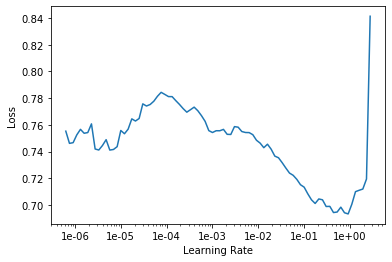

In [291]:
def get_learner(valid_idx):      
    data = TabularDataBunch.from_df(path, df_train, dep_var, 
                                    valid_idx=valid_idx,
                                    procs=procs,
                                    cat_names=cat_names,
                                    test_df=df_test,
                                    bs=32,
                                    num_workers=0)

    learn = tabular_learner(data, layers=[8,8], 
                            metrics=accuracy,
                            ps=0.25,
                            emb_drop=0.05,
                            emb_szs=emb_szs,
                            wd=1e-2,
                            callback_fns=OPTIMAL_AC)
    return learn

learn = get_learner(valid_idx)
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,OPTIMAL_AC,time
0,0.682568,0.617868,0.659193,0.748879,00:00
1,0.605319,0.464452,0.816144,0.816143,00:00
2,0.557452,0.439230,0.820628,0.825112,00:00
3,0.533129,0.424594,0.843049,0.847534,00:00
4,0.514358,0.419073,0.847534,0.847534,00:00
5,0.503333,0.414530,0.834081,0.852018,00:00
6,0.496338,0.430256,0.816144,0.829596,00:00
7,0.485207,0.419099,0.820628,0.834081,00:00
8,0.478070,0.419621,0.811659,0.834081,00:00
9,0.467747,0.406294,0.838565,0.847534,00:00


Better model found at epoch 0 with OPTIMAL_AC value: 0.7488789237668162.
Better model found at epoch 1 with OPTIMAL_AC value: 0.8161434977578476.
Better model found at epoch 2 with OPTIMAL_AC value: 0.8251121076233184.
Better model found at epoch 3 with OPTIMAL_AC value: 0.8475336322869955.
Better model found at epoch 5 with OPTIMAL_AC value: 0.852017937219731.
Better model found at epoch 10 with OPTIMAL_AC value: 0.8565022421524664.
Better model found at epoch 21 with OPTIMAL_AC value: 0.8609865470852018.


epoch,train_loss,valid_loss,accuracy,OPTIMAL_AC,time
0,0.658077,0.608788,0.681614,0.766816,00:00
1,0.597200,0.496212,0.789238,0.807175,00:00
2,0.543570,0.475287,0.784753,0.798206,00:00
3,0.511611,0.463118,0.780269,0.802691,00:00
4,0.504722,0.456780,0.802691,0.811659,00:00
5,0.492205,0.451151,0.802691,0.811659,00:00
6,0.479175,0.451508,0.802691,0.816143,00:00
7,0.472190,0.455171,0.802691,0.820628,00:00
8,0.465853,0.455788,0.775785,0.816143,00:00
9,0.458973,0.438026,0.802691,0.807175,00:00


Better model found at epoch 0 with OPTIMAL_AC value: 0.7668161434977578.
Better model found at epoch 1 with OPTIMAL_AC value: 0.8071748878923767.
Better model found at epoch 4 with OPTIMAL_AC value: 0.8116591928251121.
Better model found at epoch 6 with OPTIMAL_AC value: 0.8161434977578476.
Better model found at epoch 7 with OPTIMAL_AC value: 0.820627802690583.
Better model found at epoch 12 with OPTIMAL_AC value: 0.8251121076233184.


epoch,train_loss,valid_loss,accuracy,OPTIMAL_AC,time
0,0.723281,0.638774,0.632287,0.739910,00:00
1,0.655070,0.519735,0.753363,0.811659,00:00
2,0.599157,0.481178,0.807175,0.816143,00:00
3,0.551216,0.444015,0.811659,0.816143,00:00
4,0.528372,0.436695,0.816144,0.825112,00:00
5,0.511865,0.436931,0.820628,0.829596,00:00
6,0.499269,0.428818,0.807175,0.825112,00:00
7,0.491597,0.422288,0.829596,0.834081,00:00
8,0.478480,0.419621,0.825112,0.825112,00:00
9,0.475549,0.418133,0.829596,0.829596,00:00


Better model found at epoch 0 with OPTIMAL_AC value: 0.7399103139013453.
Better model found at epoch 1 with OPTIMAL_AC value: 0.8116591928251121.
Better model found at epoch 2 with OPTIMAL_AC value: 0.8161434977578476.
Better model found at epoch 4 with OPTIMAL_AC value: 0.8251121076233184.
Better model found at epoch 5 with OPTIMAL_AC value: 0.8295964125560538.
Better model found at epoch 7 with OPTIMAL_AC value: 0.8340807174887892.
Better model found at epoch 12 with OPTIMAL_AC value: 0.8475336322869955.


epoch,train_loss,valid_loss,accuracy,OPTIMAL_AC,time
0,0.684654,0.650400,0.644144,0.684685,00:00
1,0.643699,0.593078,0.720721,0.720721,00:00
2,0.609333,0.504520,0.774775,0.801802,00:00
3,0.580595,0.447538,0.824324,0.833333,00:00
4,0.550321,0.428590,0.833333,0.837838,00:00
5,0.535068,0.438583,0.824324,0.842342,00:00
6,0.512589,0.417889,0.833333,0.855856,00:00
7,0.502951,0.409739,0.851351,0.855856,00:00
8,0.487914,0.398551,0.855856,0.860360,00:00
9,0.484897,0.409764,0.819820,0.855856,00:00


Better model found at epoch 0 with OPTIMAL_AC value: 0.6846846846846847.
Better model found at epoch 1 with OPTIMAL_AC value: 0.7207207207207207.
Better model found at epoch 2 with OPTIMAL_AC value: 0.8018018018018018.
Better model found at epoch 3 with OPTIMAL_AC value: 0.8333333333333334.
Better model found at epoch 4 with OPTIMAL_AC value: 0.8378378378378378.
Better model found at epoch 5 with OPTIMAL_AC value: 0.8423423423423423.
Better model found at epoch 6 with OPTIMAL_AC value: 0.8558558558558559.
Better model found at epoch 8 with OPTIMAL_AC value: 0.8603603603603603.
Better model found at epoch 12 with OPTIMAL_AC value: 0.8693693693693694.


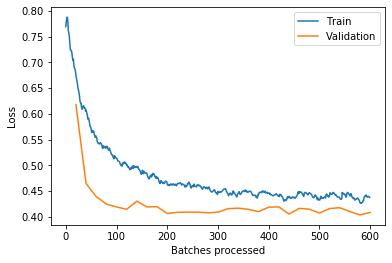

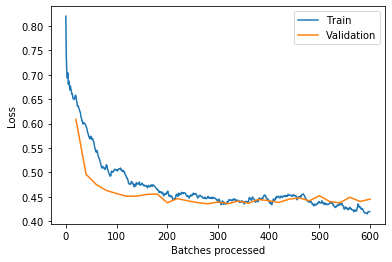

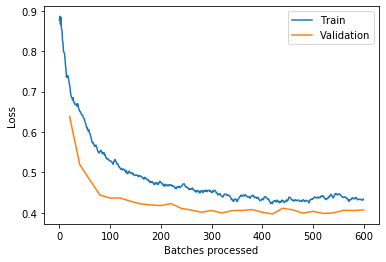

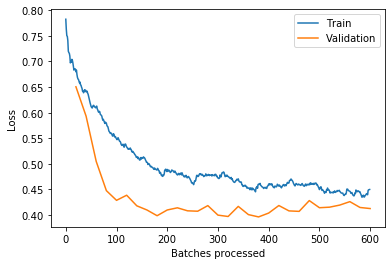

In [279]:
# K-fold implementation
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

learners = []

# for _, val_idx in skf.split(np.zeros(len(df_train)), df_train['Survived']):
#     fold_idx.append(val_idx)

for num_fold, (_ , val_idx) in enumerate(skf.split(np.zeros(len(df_train)), df_train['Survived'])):
    learn = get_learner(val_idx)
    
    learn.fit(30, 1e-2, callbacks=[SaveModelCallback(learn, every='improvement', monitor='OPTIMAL_AC', name=f'fold-{num_fold}-8-8')])
    learn.recorder.plot_losses()
    learn = learn.load(f'fold-{num_fold}-8-8')
    
    learners.append(learn)

In [280]:
def get_mean_preds(learners):
    preds = np.zeros(len(df_test))
    for learner in learners:
        preds += preds_best_treshold(learner)
    preds /= len(learners)
    return preds.argmax(1)

In [301]:
def get_vote_preds(learners):
    votes = np.zeros(len(df_test))
    for learner in learners:
        votes += preds_best_treshold(learner)
    preds = votes >= 1
    return preds.astype(int)

preds = get_vote_preds(learners)

In [302]:
preds

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0

In [284]:
votes = torch.zeros(len(df_test), dtype=int)
for learner in learners:
    votes += learner.get_preds(DatasetType.Test)[0].argmax(1)

In [285]:
votes

tensor([0, 0, 0, 0, 3, 0, 4, 0, 4, 0, 0, 0, 4, 0, 4, 4, 0, 0, 0, 4, 0, 3, 4, 1,
        4, 0, 4, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 3, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0,
        4, 1, 0, 0, 4, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 4, 4, 4, 0, 0, 4, 4, 0,
        0, 0, 4, 2, 0, 4, 0, 4, 4, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 0, 4, 0, 0, 0,
        4, 0, 3, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 4, 0, 4,
        4, 0, 4, 0, 0, 3, 0, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0,
        0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 4, 3, 0, 4, 4, 4, 4, 0, 0, 3, 0, 0,
        4, 3, 0, 0, 0, 0, 0, 4, 4, 0, 4, 4, 0, 0, 4, 0, 4, 0, 4, 0, 0, 0, 0, 0,
        3, 0, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 0, 0, 3, 0, 4, 0, 0, 0, 0, 3, 0, 0,
        4, 0, 4, 0, 4, 0, 4, 0, 4, 4, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 4,
        4, 4, 0, 0, 0, 0, 4, 0, 4, 4, 4, 0, 1, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 4,
        0, 0, 0, 0, 1, 0, 0, 0, 4, 2, 0, 4, 0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 0, 0,
        0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0,

# Submission

In [59]:
# pred = learn.predict(df_test.iloc[4])
# pred[1].item()

1

In [60]:
# preds = np.zeros(len(df_test))
# for x in range(len(df_test)):
#     preds[x] = learn.predict(df_test.iloc[x])[1].item()

In [112]:
# print(preds[:10].astype(int))

In [303]:
submission = pd.DataFrame()
submission['PassengerId'] = df_test.index
submission['Survived'] = preds

In [304]:
submission.to_csv('submission.csv', index=False)